In [26]:
import wfdb
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

In [3]:
path = "../arrythmia/"
signal = wfdb.rdrecord(path + str(100)).p_signal[np.newaxis,:,:]
print(signal.shape)
annotations=wfdb.rdann(path+str(100),extension="atr")
for i in range(101, 125):
    if os.path.exists(path + str(i) + ".dat"):
        record= wfdb.rdrecord(path + str(i)).p_signal
        recordAnnotation=wfdb.rdann(path+str(i),extension="atr")
        signal=np.append(signal,record[np.newaxis,:,:],axis=0)
        annotations=np.append(annotations,recordAnnotation)
        

for i in range(200, 235):
    if os.path.exists(path + str(i) + ".dat"):
        record= wfdb.rdrecord(path + str(i)).p_signal
        recordAnnotation=wfdb.rdann(path+str(i),extension="atr")
        signal=np.append(signal,record[np.newaxis,:,:],axis=0)
        annotations=np.append(annotations,recordAnnotation)
print(signal.shape)

(1, 650000, 2)
(48, 650000, 2)


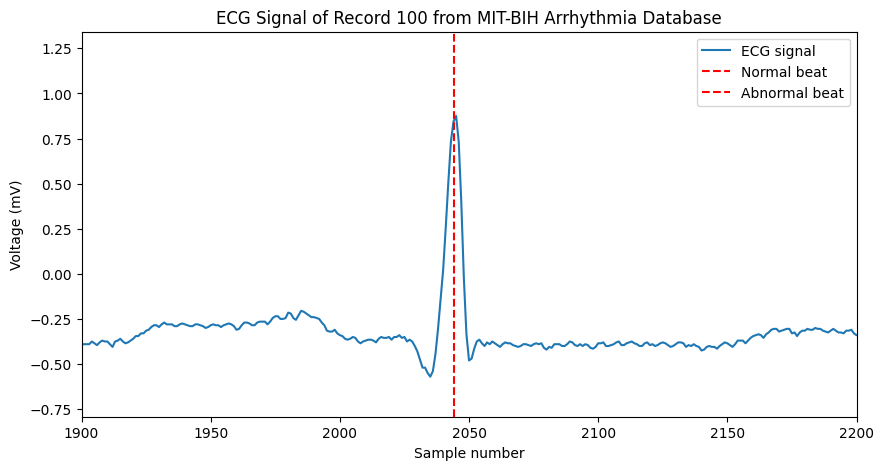

In [52]:
record = signal[0]
annotation = annotations[0]

# Plot the ECG signal
plt.figure(figsize=(10, 5))
plt.plot(record[:100000, 0])
plt.xlabel('Sample number')
plt.ylabel('Voltage (mV)')
plt.title('ECG Signal of Record 100 from MIT-BIH Arrhythmia Database')

# Plot the annotations
for i, time in enumerate(annotation.sample):
    # if annotation.symbol[i] in ['N', 'L', 'R', 'B']:
        # plt.axvline(x=time, color='purple', linestyle='--')
    if annotation.symbol[i] in ['A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E']:
        plt.axvline(x=time, color='red', linestyle='--')
plt.xlim(1900,2200)
plt.legend(['ECG signal', 'Normal beat', 'Abnormal beat'])
plt.show()
# plt.savefig("sample0-1000ch2.png")

In [4]:
print(signal[0])
print(len(annotations[0].symbol))


[[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 ...
 [-0.675 -0.365]
 [-0.765 -0.335]
 [-1.28   0.   ]]
2274


In [5]:
# Feature Extraction definition
FEATURES = ['MIN','MAX','MEAN','RMS','VAR','STD','POWER','PEAK','P2P','CREST FACTOR','SKEW','KURTOSIS',
            'MAX_f','SUM_f','MEAN_f','VAR_f','PEAK_f','SKEW_f','KURTOSIS_f',"arrhythmia"]
Min=[];Max=[];Mean=[];Rms=[];Var=[];Std=[];Power=[];Peak=[];Skew=[];Kurtosis=[];P2p=[];CrestFactor=[];
FormFactor=[]; PulseIndicator=[];
Max_f=[];Sum_f=[];Mean_f=[];Var_f=[];Peak_f=[];Skew_f=[];Kurtosis_f=[]

In [6]:
#feature extraction function for statisical features 
def features_extraction(X):
    #time domain and frequency domain features
    Min.append(np.min(X))
    Max.append(np.max(X))
    Mean.append(np.mean(X))
    Rms.append(np.sqrt(np.mean(X**2)))
    Var.append(np.var(X))
    Std.append(np.std(X))
    Power.append(np.mean(X**2))
    Peak.append(np.max(np.abs(X)))
    P2p.append(np.ptp(X))
    CrestFactor.append(np.max(np.abs(X))/np.sqrt(np.mean(X**2)))
    Skew.append(stats.skew(X))
    Kurtosis.append(stats.kurtosis(X))
    FormFactor.append(np.sqrt(np.mean(X**2))/np.mean(X))
    PulseIndicator.append(np.max(np.abs(X))/np.mean(X))
    ## FREQ DOMAIN ##
    ft = fft(X)
    S = np.abs(ft**2)/len(X)
    Max_f.append(np.max(S))
    Sum_f.append(np.sum(S))
    Mean_f.append(np.mean(S))
    Var_f.append(np.var(S))
    
    Peak_f.append(np.max(np.abs(S)))
    Skew_f.append(stats.skew(X))
    Kurtosis_f.append(stats.kurtosis(X))

In [7]:
symbols=[]
for i in range(0,48):
    if annotations[i].symbol[0] in ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'F', 'e']:
        data=signal[i,0:annotations[i].sample[0],0]
        features_extraction(data)
        symbols.append(annotations[i].symbol[j])
        data=signal[i,0:annotations[i].sample[0],1]
        features_extraction(data)
        symbols.append(annotations[i].symbol[0])
    for j in range(1,len(annotations[i].sample)):
        if annotations[i].symbol[j] in ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'F', 'e']:
            data=signal[i,annotations[i].sample[j-1]:annotations[i].sample[j],0]
            symbols.append(annotations[i].symbol[j])
            features_extraction(data)
            data=signal[i,annotations[i].sample[j-1]:annotations[i].sample[j],1]
            symbols.append(annotations[i].symbol[j])
            features_extraction(data)

In [8]:
print(len(Min))

202232


In [11]:
df_features = pd.DataFrame(index = [FEATURES], 
                               data = [Min,Max,Mean,Rms,Var,Std,Power,Peak,P2p,CrestFactor,Skew,Kurtosis,
                                       Max_f,Sum_f,Mean_f,Var_f,Peak_f,Skew_f,Kurtosis_f,symbols])
df_features

,0,1,2,3,4,5,6,7,8,9,...,202222,202223,202224,202225,202226,202227,202228,202229,202230,202231
MIN,-0.485,-0.3,-0.535,-0.36,-0.57,-0.47,-0.645,-0.425,-0.565,-0.395,...,-0.435,-0.08,-0.365,-0.105,-0.41,-0.08,-0.43,-0.125,-0.35,-0.135
MAX,0.78,0.58,0.875,0.495,0.94,0.705,0.96,0.655,0.86,0.545,...,1.615,0.775,1.725,0.655,1.68,0.645,1.54,0.71,1.67,0.6
MEAN,-0.225085,-0.065254,-0.287321,-0.195085,-0.332586,-0.230445,-0.344665,-0.231919,-0.32214,-0.235474,...,-0.187905,0.083071,-0.167407,0.079177,-0.224365,0.07006,-0.199652,0.03418,-0.156886,0.021419
RMS,0.31121,0.193244,0.328626,0.217213,0.373395,0.26362,0.385523,0.267289,0.361479,0.257889,...,0.369002,0.143982,0.361284,0.13337,0.3671,0.119058,0.357333,0.11579,0.344409,0.107421
VAR,0.046189,0.033085,0.025442,0.009123,0.028811,0.01639,0.029833,0.017657,0.026893,0.011059,...,0.100854,0.01383,0.102501,0.011519,0.084423,0.009267,0.087826,0.012239,0.094005,0.011081
STD,0.214915,0.181893,0.159506,0.095516,0.169737,0.128025,0.172724,0.132879,0.16399,0.10516,...,0.317575,0.117602,0.320158,0.107325,0.290556,0.096263,0.296354,0.11063,0.306602,0.105264
POWER,0.096852,0.037343,0.107995,0.047182,0.139424,0.069495,0.148628,0.071443,0.130667,0.066506,...,0.136162,0.020731,0.130526,0.017788,0.134762,0.014175,0.127687,0.013407,0.118618,0.011539
PEAK,0.78,0.58,0.875,0.495,0.94,0.705,0.96,0.655,0.86,0.545,...,1.615,0.775,1.725,0.655,1.68,0.645,1.54,0.71,1.67,0.6
P2P,1.265,0.88,1.41,0.855,1.51,1.175,1.605,1.08,1.425,0.94,...,2.05,0.855,2.09,0.76,2.09,0.725,1.97,0.835,2.02,0.735
CREST FACTOR,2.506346,3.001388,2.662598,2.278867,2.517442,2.674306,2.490126,2.450534,2.379114,2.113316,...,4.376675,5.382605,4.774637,4.911136,4.576412,5.41751,4.30971,6.131778,4.848883,5.585493


In [12]:
df_features=df_features.transpose()
df_features

,MIN,MAX,MEAN,RMS,VAR,STD,POWER,PEAK,P2P,CREST FACTOR,SKEW,KURTOSIS,MAX_f,SUM_f,MEAN_f,VAR_f,PEAK_f,SKEW_f,KURTOSIS_f,arrhythmia
0,-0.485,0.78,-0.225085,0.31121,0.046189,0.214915,0.096852,0.78,1.265,2.506346,3.074325,10.443485,2.989125,5.71425,0.096852,0.149888,2.989125,3.074325,10.443485,N
1,-0.3,0.58,-0.065254,0.193244,0.033085,0.181893,0.037343,0.58,0.88,3.001388,2.229329,4.541907,0.268512,2.20325,0.037343,0.00622,0.268512,2.229329,4.541907,N
2,-0.535,0.875,-0.287321,0.328626,0.025442,0.159506,0.107995,0.875,1.41,2.662598,5.35795,31.927254,24.188103,31.642625,0.107995,1.989414,24.188103,5.35795,31.927254,N
3,-0.36,0.495,-0.195085,0.217213,0.009123,0.095516,0.047182,0.495,0.855,2.278867,4.39039,25.940657,11.151077,13.8242,0.047182,0.422811,11.151077,4.39039,25.940657,N
4,-0.57,0.94,-0.332586,0.373395,0.028811,0.169737,0.139424,0.94,1.51,2.517442,5.19586,31.453586,32.299052,40.711725,0.139424,3.558928,32.299052,5.19586,31.453586,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202227,-0.08,0.645,0.07006,0.119058,0.009267,0.096263,0.014175,0.645,0.725,5.41751,3.096847,14.943577,1.236901,3.572075,0.014175,0.006681,1.236901,3.096847,14.943577,N
202228,-0.43,1.54,-0.199652,0.357333,0.087826,0.296354,0.127687,1.54,1.97,4.30971,4.267919,19.429201,9.72603,31.155525,0.127687,0.440789,9.72603,4.267919,19.429201,N
202229,-0.125,0.71,0.03418,0.11579,0.012239,0.11063,0.013407,0.71,0.835,6.131778,3.398698,16.723278,0.30628,3.2714,0.013407,0.001584,0.30628,3.398698,16.723278,N
202230,-0.35,1.67,-0.156886,0.344409,0.094005,0.306602,0.118618,1.67,2.02,4.848883,4.426384,20.349437,5.808689,27.993775,0.118618,0.206838,5.808689,4.426384,20.349437,N


In [21]:
df_features.to_csv("statisticalFeatures.csv",index=False)